## Q3. Develop a trading strategy to trade either an asset or a combination of assets in the given global futures/ETFs ##

## Introduction

* Time Series Momentum strategy was chosen. 

* Only the data of ETFs were chosen because of their simplicity as opposed to futures, which have more complex mechanics

* 7 ETFs were chosen for the following reasons:
    1. AGG: US Bonds
    2. DBC: US Commodities
    3. EEM: Emerging markets
    4. EFA: Developed markets excluding the US
    5. GLD: Gold
    6. SPY: US Equity
    7. VNQ: US Real Estate

    Generally, factors that were considered were a mixture of the major asset classes and diversification across US and non-US assets

* Two research papers were chosen:
    1. Hurst, Ooi & Pedersen (2017) — “A Century of Evidence on Trend-Following Investing”
    2. Moskowitz, Ooi & Pedersen (2012) — “Time Series Momentum”

## Inspiration from papers 
- Hurst, Ooi & Pedersen (2017) test equal-weighted 1-month, 3-month, and 12-month time-series momentum stategies

- The position taken for each market is determined by assessing the past return in that market over the relevant lookback horizon

- A positive trend is considered an "up" position; a negative trend is considered a "down" position

- The positions are aggregrated each month

- The positions are scaled such that the combined portfolio has an annualized ex ante volatility target of 10% annualized

- Moskowitz, Ooi & Pedersen (2012) size each of their positions inversely to their respective volatilities

# Main Procedure 

## 1. Import required libraries and data
* Form dictionary of ETF data
* Align data to common calendar before forward filling
* Set parameters for signals and rolling walk-forward

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas.tseries.offsets import BDay

etf_folder = 'ETFs'

etf_dict = {}
for file in os.listdir(etf_folder):
    name = os.path.splitext(file)[0]
    file_path = os.path.join(etf_folder, file)
    df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date") 
    etf_dict[name] = pd.to_numeric(df["Close"], errors="coerce")

prices_main = pd.DataFrame(etf_dict).asfreq("B").ffill()
# align all data to common calendar then fwd fill

### PARAMETERS ###  
lookback_days = [63, 126, 252] # 3M, 6M, 12M
VOL_LOOKBACK = 63 # 3 months
TARGET_VOL = 0.1
PAD_DAYS = max(lookback_days) + VOL_LOOKBACK # min for 1st OOS day
TRAIN_YEARS = 3    
TEST_YEARS = 1 

## 2. TSM Stategy function

### Signal calculation
- For every ETF, we determine its signal based on each of its lookback periods (each horizon). So every ETF will have three signals.

- For a positive return, the signal is +1, and a negative return gives -1

- Since there are three periods, we sum the signals of each ETF across the horizon and find the average of each one

### Volatility weighing
- Annualised volatility is first found via the percentage changes 

- As with Moskowitz, Ooi & Pedersen (2012), we calculate volatility weightings by inversing them

- Weekly and then daily resamples are done before normalised weights are achieved. These are needed as the earlier years (before 2000s) only consist of 1-2 ETF trading data, and the missing ETFs need to be accounted for

- Ex ante volatility targetting is subsequently applied to achieve the target of 10% as is done within Hurst, Ooi & Pedersen (2017) 

In [13]:
def tsmom_strat(price_range, vol_lookback=VOL_LOOKBACK, target_vol=TARGET_VOL):
    """daily port rets for given price range"""
    price_range = price_range.asfreq("B") # align all to be business days
    perct_changes = price_range.pct_change() # %changes

    # list of DFs
    signals = [np.sign(price_range / price_range.shift(k) - 1.0) for k in lookback_days]

    # avg signal
    sum_hrzt, count_no_hrzt = None, None
    for signal in signals:
        if sum_hrzt is None: # first iteration
            sum_hrzt = signal # initialise sum with the first signal df
            count_no_hrzt = signal.notna().astype(int) # count no of signals across
        else: # subsequent iterations
            sum_hrzt = sum_hrzt.add(signal, fill_value=0) # resulting NaN become 0
            count_no_hrzt = count_no_hrzt.add(signal.notna().astype(int), fill_value=0) 
            # count no of signals across, any NaN become 0

    avg_sig = sum_hrzt.div(count_no_hrzt.replace(0, np.nan)) # div to find avgs

    ### normalising weights ###
    daily_vol = perct_changes.rolling(vol_lookback).std()
    ann_vol = daily_vol * np.sqrt(252)
    weights = (avg_sig / ann_vol).replace([np.inf, -np.inf], np.nan)
    weekly_rebal_weights = weights.resample("W-FRI").last().ffill() # rebal to fri weight
    daily_rebal_weights = weekly_rebal_weights.reindex(perct_changes.index).ffill() 
    # expand fri weight to subsequent week

    sum_weights = daily_rebal_weights.abs().sum(axis=1).replace(0, np.nan)
    # summing up absol weights across each etf

    norm_weights = daily_rebal_weights.div(sum_weights, axis=0).fillna(0.0)
    # dividing to obtain normalised weights, to cater to some ETFs existing before others
    
    ### ex ante vol targeting ###
    port_vol_daily = np.sqrt((norm_weights.pow(2) * daily_vol.pow(2)).sum(axis=1))
    #ignore cov term, use diagonal approx (use only each asset's own var)

    k = (target_vol / np.sqrt(252)) / port_vol_daily
    # scale factor k for forecast to hit target vol

    k = k.replace([np.inf, -np.inf], np.nan).fillna(1.0)
    # replace infs with NaNs then with 1.0

    scaled_weights = norm_weights.mul(k, axis=0)
    # apply k to weight vector 

    port_rets = (scaled_weights.shift(1) * perct_changes).sum(axis=1).fillna(0.0)
    # use D_t-1 weights for D_1 to avoid clairvoyance
    
    return port_rets



## 3. Rolling Walk Forward Analysis

- To conserve data while ensuring sufficient training data, 3 training years and 1 testing year will be continuously applied on a rolling basis to the model

- The final number of accumulated out-of-sample years is calculated at the end, and it easily exceeds the requirement of 5 years

- Padding is also included within the analysis to minimally ensure that the first day of every new cycle will have sufficient data to draw from


In [14]:
idx = prices_main.index
roll_over = idx[0]
oos_res = []
oos_count = 0

while True:
    train_start = roll_over
    train_end = train_start + pd.DateOffset(years=TRAIN_YEARS) - pd.DateOffset(days=1)
    test_start = train_end + pd.DateOffset(days=1)
    test_end = test_start + pd.DateOffset(years=TEST_YEARS) - pd.DateOffset(days=1)
    if test_end > idx[-1]:
        break

    # padding so day-1 of OOS has valid momentum/vol
    start_with_pad = test_start - BDay(PAD_DAYS)
    start_with_pad= max(start_with_pad, idx[0]) # in case padding exceeds first available date
    pad_window = prices_main.loc[start_with_pad:test_end]

    # ensure ETF has sufficient OOS dates
    pre_hist = pad_window.loc[start_with_pad : (test_start - BDay(1))]
    valid_etf = []
    for col in pad_window.columns:
        if pre_hist[col].notna().sum() >= PAD_DAYS: 
            valid_etf.append(col)
    
    if len(valid_etf) < 2: # immediate rollover if insufficient etf
        roll_over = train_start + pd.DateOffset(years=1)
        oos_count += TEST_YEARS
        continue

    pad_window = pad_window[valid_etf] # filter only for valid etf with padded window
    res = tsmom_strat(pad_window, vol_lookback=VOL_LOOKBACK, target_vol=TARGET_VOL)
    oos_res.append(res.loc[test_start:test_end])

    roll_over = train_start + pd.DateOffset(years=1) # roll to next window by one year
    oos_count += TEST_YEARS

total_returns = pd.concat(oos_res).sort_index()

## 4. Plotting

Use ```matplotlib``` to plot the growth of one unit (one dollar) invested in the chosen basket of ETFs over the years of data available to us.

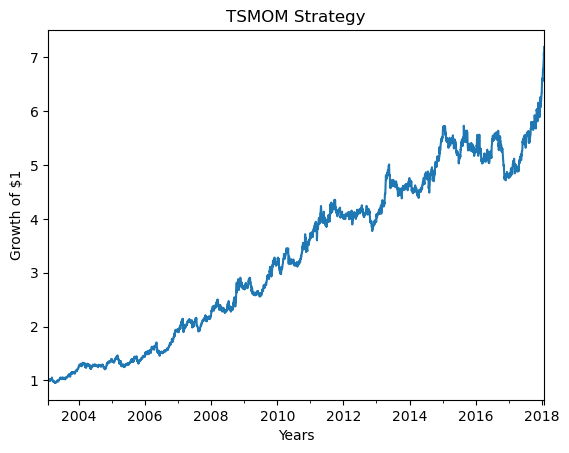

Annualised mean return: 0.1382
Annualised volatility: 0.149
Sharpe: 0.9274
Accumulative out-of-sample years: 22


In [15]:
equity = (1 + total_returns).cumprod()
ax = equity.plot(title="TSMOM Strategy")
ax.set_xlabel("Years"); ax.set_ylabel("Growth of $1")
plt.show()

def stats(r):
    ann_mu_ret = r.mean() * 252
    ann_vol = r.std() * np.sqrt(252)
    sharpe = 0 if ann_vol == 0 else ann_mu_ret / ann_vol  # avoid DivByZero
    print(f"Annualised mean return: {round(ann_mu_ret, 4)}")
    print(f"Annualised volatility: {round(ann_vol, 4)}")
    print(f"Sharpe: {round(sharpe, 4)}")
    print(f"Accumulative out-of-sample years: {oos_count}")
stats(total_returns)

## Conclusion 
From the graph, we can see an obvious upwards trend which is reflective of the strength of this time-series momentum strategy based off volatility weighing and targeting.

It also has a Sharpe ratio of 0.927 which is towards the higher end of the ratios of the strategies tested in Hurst, Ooi & Pedersen (2017) in Exhibit 2, where most of the methodology for this strategy had drawn inspiration from in the first place.

While it may be biased towards ETFs, it is shown to be a decently strong strategy regardless.

## Limitations 
- Only ETFs are being tested upon, which largely limits any achievable results to only ETFs as opposed to other securities like futures

- The chosen ETFs start at varying points in time, with most of them only from the early 2000s onwards. The data is thus dependent on how effective the normalised weights and filter within the rolling walk forward analysis are

- Volatility lookback period was chosen to be three months without any strong reason, which may end up being insufficient or even too long of a period

- Diagonal volatility approximation was used in volatility targeting, possibly resulting in an under or overestimation of the true portfolio risk